## Transfer learning based on VGG16 with logistic Regression

The main idea here is to try out different combinations of VGG16 together with a logistic Regression model to find which layers of VGG16 are needed to classify an image as blurry or out of focus. In a next step, the hyperparameters of the most promising combinations will be tested. 

In [1]:
# plotting imports and setup
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.figsize'] = [10,10]

First we have to import the dataset.

In [2]:
from keras.preprocessing import image
from os import listdir
from keras.applications.vgg16 import preprocess_input

fdir='Data/CERTH_ImageBlurDataset/TrainingSet/Naturally-Blurred/'
files= listdir(fdir)
X=[] #feature vector
images=[]
Y=[] #class vector (1='blurred', 0='in focus')
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images.append(x)
    x=image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    X.append(x)
    Y.append(1)
    
fdir='Data/CERTH_ImageBlurDataset/TrainingSet/Undistorted/'
files= listdir(fdir)
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images.append(x)
    x=image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    X.append(x)
    Y.append(0)

/Users/albert/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next we import VGG16 and look at the predefined classification

('Predicted:', [(u'n03788195', u'mosque', 0.60078186), (u'n04562935', u'water_tower', 0.105923414), (u'n03956157', u'planetarium', 0.09694916)])


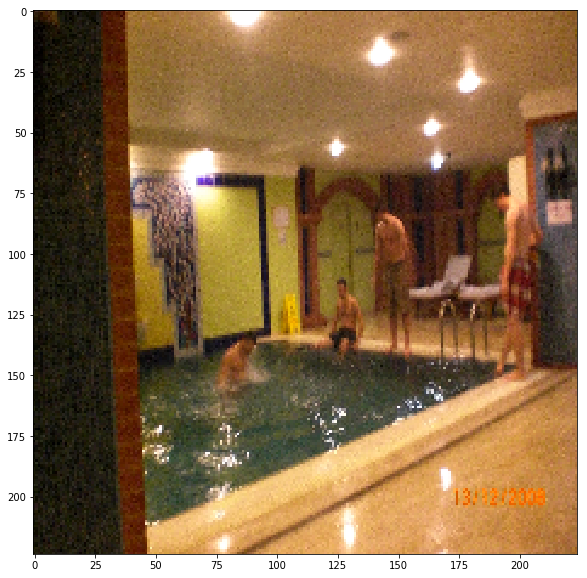

In [3]:
##first example with full classification
from keras import applications
from keras.applications.vgg16 import decode_predictions


#load the VGG16 network
model = applications.VGG16(weights='imagenet')
img = X[0]
preds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])
plt.imshow(images[0])

### Establishing baseline for classification accuracy

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                  test_size=0.7,
                                                  random_state=10)

#### Prediction accuracy of Dummy Classifier

In [5]:
reshape=np.shape(X_train)[1]*np.shape(X_train)[2]*np.shape(X_train)[3]*np.shape(X_train)[4]
X_train_flat=np.array(X_train).reshape(len(X_train),reshape)
X_test_flat=np.array(X_test).reshape(len(X_test),reshape)

In [6]:
from sklearn.dummy import DummyClassifier

dcl = DummyClassifier()
dcl.fit(X_train_flat, y_train)

#evaluate the performance of the classifier on your training dataset
print("Train: {:.3f}".format(dcl.score(X_train_flat, y_train)))
#evaluate the performance of the classifier on your testing dataset
print("Test: {:.3f}".format(dcl.score(X_test_flat, y_test)))

Train: 0.678
Test: 0.630


#### Prediction accuracy of Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_flat, y_train)

#evaluate the performance of the classifier on your training dataset
print("Train: {:.3f}".format(rfc.score(X_train_flat, y_train)))
#evaluate the performance of the classifier on your testing dataset
print("Test: {:.3f}".format(rfc.score(X_test_flat, y_test)))

Train: 0.984
Test: 0.745


Also try with optimized hyper-parameters.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_grid = {'n_estimators':  sp_randint(10,50),
             'max_features': sp_uniform(0,1),
             'max_depth':sp_randint(5,50)
             }

#RandomForrestClassifier
opt_grid_rfc = {}

grid = RandomizedSearchCV(RandomForestClassifier(),verbose=1,  param_distributions=param_grid,n_iter=30, cv=2)
grid.fit(X_train_flat, y_train)
opt_grid_rfc=grid.best_params_

rfc = RandomForestClassifier(**opt_grid_rfc).fit(X_train_flat,y_train)
print 'RandomForrestClassifier stats'
print 'training score: ', rfc.score(X_train_flat,y_train)
print 'test score: ',rfc.score(X_test_flat,y_test)
print("best parameters: {}".format(opt_grid_rfc))

Fitting 2 folds for each of 30 candidates, totalling 60 fits


### Using VGG16 for feature extraction

In [ ]:
vgg= image.load_img('Figures/vgg.png') 
plt.imshow(vgg)

Structure of VGG16

#### Starting with the last layer

In [ ]:
model = applications.VGG16(include_top=False,weights='imagenet')

X_train_ = []
for xx in X_train:
    X_train_.append( model.predict(xx) )
    
X_test_ = []
for xx in X_test:
    X_test_.append( model.predict(xx) )

In [ ]:
reshape=np.shape(X_train_)[1]*np.shape(X_train_)[2]*np.shape(X_train_)[3]*np.shape(X_train_)[4]
X_train__=np.array(X_train_).reshape(len(X_train_),reshape)
X_test__=np.array(X_test_).reshape(len(X_test_),reshape)

In [ ]:
#train a logistic regression to get from X to y
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train__,y_train)
print 'LogisticRegression stats'
print 'training score: ', lr.score(X_train__,y_train)
print 'test score: ',lr.score(X_test__,y_test)

Also compare to a dummy classifier instead of the logistic regression classifier

In [ ]:
dcl = DummyClassifier()
dcl.fit(X_train__, y_train)

#evaluate the performance of the classifier on your training dataset
print("Train: {:.3f}".format(dcl.score(X_train__, y_train)))
#evaluate the performance of the classifier on your testing dataset
print("Test: {:.3f}".format(dcl.score(X_test__, y_test)))

#### use output from 2nd-last max-pooling

In [ ]:
#after 4th max-pooling
from keras.models import Model

base_model = applications.VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

X_train_ = []
for xx in X_train:
    X_train_.append( model.predict(xx) )
    
X_test_ = []
for xx in X_test:
    X_test_.append( model.predict(xx) )

In [ ]:
reshape=np.shape(X_train_)[1]*np.shape(X_train_)[2]*np.shape(X_train_)[3]*np.shape(X_train_)[4]
X_train__=np.array(X_train_).reshape(len(X_train_),reshape)
X_test__=np.array(X_test_).reshape(len(X_test_),reshape)

In [ ]:
#train a logistic regression to get from X to y
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train__,y_train)
print 'LogisticRegression stats'
print 'training score: ', lr.score(X_train__,y_train)
print 'test score: ',lr.score(X_test__,y_test)

#### use output from 3rd max-pooling

In [ ]:
#after 3rd max-pooling
from keras.models import Model

base_model = applications.VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)

X_train_ = []
for xx in X_train:
    X_train_.append( model.predict(xx) )
    
X_test_ = []
for xx in X_test:
    X_test_.append( model.predict(xx) )

In [ ]:
reshape=np.shape(X_train_)[1]*np.shape(X_train_)[2]*np.shape(X_train_)[3]*np.shape(X_train_)[4]
X_train__=np.array(X_train_).reshape(len(X_train_),reshape)
X_test__=np.array(X_test_).reshape(len(X_test_),reshape)

In [ ]:
#train a logistic regression to get from X to y
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train__,y_train)
print 'LogisticRegression stats'
print 'training score: ', lr.score(X_train__,y_train)
print 'test score: ',lr.score(X_test__,y_test)

#### use output from 2nd max-pooling

In [ ]:
#after 2nd max-pooling
from keras.models import Model

base_model = applications.VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block2_pool').output)

X_train_ = []
for xx in X_train:
    X_train_.append( model.predict(xx) )
    
X_test_ = []
for xx in X_test:
    X_test_.append( model.predict(xx) )

In [ ]:
reshape=np.shape(X_train_)[1]*np.shape(X_train_)[2]*np.shape(X_train_)[3]*np.shape(X_train_)[4]
X_train__=np.array(X_train_).reshape(len(X_train_),reshape)
X_test__=np.array(X_test_).reshape(len(X_test_),reshape)

In [ ]:
#train a logistic regression to get from X to y
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train__,y_train)
print 'LogisticRegression stats'
print 'training score: ', lr.score(X_train__,y_train)
print 'test score: ',lr.score(X_test__,y_test)

#### use output from 1st max-pooling

In [ ]:
#after 1st max-pooling
from keras.models import Model

base_model = applications.VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_pool').output)

X_train_ = []
for xx in X_train:
    X_train_.append( model.predict(xx) )
    
X_test_ = []
for xx in X_test:
    X_test_.append( model.predict(xx) )

In [ ]:
reshape=np.shape(X_train_)[1]*np.shape(X_train_)[2]*np.shape(X_train_)[3]*np.shape(X_train_)[4]
X_train__=np.array(X_train_).reshape(len(X_train_),reshape)
X_test__=np.array(X_test_).reshape(len(X_test_),reshape)

In [ ]:
#train a logistic regression to get from X to y
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train__,y_train)
print 'LogisticRegression stats'
print 'training score: ', lr.score(X_train__,y_train)
print 'test score: ',lr.score(X_test__,y_test)

#### optimizing the hyperparameters
It seems that using the output directly from last max-pooling layer gives the best results.
Now we are going to try to get an even better accuracy by optimizing the hyperparameters for Logistic Regression Model.

In [ ]:
model = applications.VGG16(include_top=False,weights='imagenet')

X_train_ = []
for xx in X_train:
    X_train_.append( model.predict(xx) )
    
X_test_ = []
for xx in X_test:
    X_test_.append( model.predict(xx) )

In [ ]:
reshape=np.shape(X_train_)[1]*np.shape(X_train_)[2]*np.shape(X_train_)[3]*np.shape(X_train_)[4]
X_train__=np.array(X_train_).reshape(len(X_train_),reshape)
X_test__=np.array(X_test_).reshape(len(X_test_),reshape)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_grid = {'C':  sp_uniform(0,10), 
              'intercept_scaling': sp_uniform(0,10),
             'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'tol': sp_uniform(0,0.01)
             }

opt_grid_lr = {}

grid = RandomizedSearchCV(LogisticRegression(),  param_distributions=param_grid,n_iter=100, cv=2)
grid.fit(X_train__, y_train)
opt_grid_lr=grid.best_params_

lr = LogisticRegression(**opt_grid_lr).fit(X_train__,y_train)
print 'LogisticRegression stats'
print 'training score: ', lr.score(X_train__,y_train)
print 'test score: ',lr.score(X_test__,y_test)
print("best parameters: {}".format(opt_grid_lr))

## Final evaluation on the test-set

Finally we are going to load the test set from the CERTH Image Blur Dataset to see how well the ML model performs.

In [ ]:
X_train = X
y_train = Y

In [ ]:
import pandas as pd
fn='Data/CERTH_ImageBlurDataset/EvaluationSet/NaturalBlurSet.xlsx'
xl = np.array(pd.read_excel(fn))
val={}
for xx in xl:
    val[xx[0]]=xx[1]

In [ ]:
fdir='Data/CERTH_ImageBlurDataset/EvaluationSet/NaturalBlurSet/'
files= listdir(fdir)
X_test=[] #feature vector
images=[]
y_test=[] #class vector (1='blurred', 0='in focus')
for fn in files:
    img_path = fdir+fn
    x=image.load_img(img_path, target_size=(224, 224))
    images.append(x)
    x=image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    X_test.append(x)
    y_test.append((val[fn[:-4]]+1)/2)

#### Accuracy for Benchmarks

#### Prediction accuracy of Dummy Classifier

In [ ]:
reshape=np.shape(X_train)[1]*np.shape(X_train)[2]*np.shape(X_train)[3]*np.shape(X_train)[4]
X_train_flat=np.array(X_train).reshape(len(X_train),reshape)
X_test_flat=np.array(X_test).reshape(len(X_test),reshape)

In [ ]:
from sklearn.dummy import DummyClassifier

dcl = DummyClassifier()
dcl.fit(X_train_flat, y_train)

#evaluate the performance of the classifier on your training dataset
print("Train: {:.3f}".format(dcl.score(X_train_flat, y_train)))
#evaluate the performance of the classifier on your testing dataset
print("Test: {:.3f}".format(dcl.score(X_test_flat, y_test)))

#### Prediction accuracy of Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(**opt_grid_rfc).fit(X_train_flat,y_train)
rfc.fit(X_train_flat, y_train)

#evaluate the performance of the classifier on your training dataset
print("Train: {:.3f}".format(rfc.score(X_train_flat, y_train)))
#evaluate the performance of the classifier on your testing dataset
print("Test: {:.3f}".format(rfc.score(X_test_flat, y_test)))

#### Prediction accuracy for chosen VGG16 model with Logistic Regression

In [ ]:
model = applications.VGG16(include_top=False,weights='imagenet')

X_train_ = []
for xx in X_train:
    X_train_.append( model.predict(xx) )
    
X_test_ = []
for xx in X_test:
    X_test_.append( model.predict(xx) )

reshape=np.shape(X_train_)[1]*np.shape(X_train_)[2]*np.shape(X_train_)[3]*np.shape(X_train_)[4]
X_train__=np.array(X_train_).reshape(len(X_train_),reshape)
X_test__=np.array(X_test_).reshape(len(X_test_),reshape)

#train a logistic regression to get from X to y
#LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(**opt_grid_lr).fit(X_train__,y_train)
print 'LogisticRegression stats'
print 'training score: ', lr.score(X_train__,y_train)
print 'test score: ',lr.score(X_test__,y_test)

#### Prediction accuracy for VGG16 with Dummy Classifier

In [ ]:
dcl = DummyClassifier()
dcl.fit(X_train__, y_train)

#evaluate the performance of the classifier on your training dataset
print("Train: {:.3f}".format(dcl.score(X_train__, y_train)))
#evaluate the performance of the classifier on your testing dataset
print("Test: {:.3f}".format(dcl.score(X_test__, y_test)))